# Bee Image Classification using a CNN to detect Varroa mite infestation

#### By: Mahdi Shadkam-Farrokhi: [GitHub](https://github.com/Shaddyjr) | [Medium](https://medium.com/@mahdis.pw) | [http://mahdis.pw](http://mahdis.pw)

## Problem Statement
Of the [many likely causes](https://www.sciencenewsforstudents.org/article/why-are-bees-vanishing-pesticides-disease-other-threats) behind the drastic decline in the honey bee population, the _Varroa (pronounced "vr-ow-uh") destructor_, or more commonly the _varroa mite_, is among the top contributors. As a natural predator to honey bees, the varroa mite is one of the biggest pests plaguing the bee keeping community. 


While small, these mites are difficult for bees to deal with. However, bee keepers can employ a number of treatments to help rid a hive of a varroa infestation. The sooner a bee keeper can begin treatment, the less likely a [colony collapse](https://ipm.missouri.edu/MPG/2013/7/Colony-Collapse-Disorder-the-Varroa-Mite-and-Resources-for-Beekeepers/) will occur.

Having an tool to quickly assess a colony's health could mean the difference between a healthy hive and a dead one. I plan to create that tool using the dataset from the [Honey Bee Annotated Image Dataset](https://www.kaggle.com/jenny18/honey-bee-annotated-images) found on Kaggle.

Using this dataset, I will use a Convolutional Neural Network to create a predictive model to determine if a bee image shows evidence of varroa mites or not (binary classification).

A bee hive with a varroa mite infestation can quickly end up dead from varroa collapse. As such, falsely classifying an image as clear could be disastrous. Therefore, recall, or sensativity, will be the metric I use for model selection.

## Table of contents

- [Data Dictionary](#Data-Dictionary)
- [Imports and loading Data](#Imports-and-loading-Data)
- [Preliminary EDA](#Preliminary-EDA)
    - [Handling target variable](#Handling-target-variable)
    - [Clearing unnecessary columns](#Clearing-unnecessary-columns)
    - [Visualizing file images](#Visualizing-file-images)
- [Source Documentation](#Source-Documentation)

## Data Dictionary
The data used for this analysis was taken directly from the [Honey Bee Annotated Image Dataset](https://www.kaggle.com/jenny18/honey-bee-annotated-images) fround on Kaggle.

The following is the data dictionary for the original dataset:

|column|type|description|
|-|-|-|
|file|string|name of file in 'bee_imgs' folder|
|date|string|date image was captured|
|time|string|time of day of image capture (military time)|
|location|string|Location (city, state, country)|
|zip|int| Zip code of the location|
|subspecies|string|Subspecies of _Apis mellifera_ species|
|health|string|Health of the bee|
|pollen_carrying|boolean|Presence of pollen on the bee's legs|
|caste|string|Worker, Drone, or Queen bee|

## Imports and loading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imageio
from skimage.transform import rescale, resize, rotate
from sklearn.metrics import confusion_matrix, auc
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import warnings
warnings.filterwarnings("ignore")

random_state = 42

# For reproducibility
np.random.seed(random_state)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
data = pd.read_csv('./data/bee_data.csv')

In [3]:
data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [4]:
data.shape

(5172, 9)

## Preliminary EDA

### Handling target variable

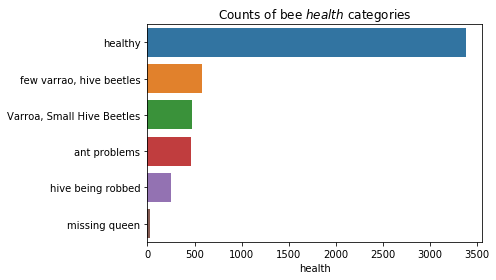

In [5]:
health_counts = data["health"].value_counts()

plt.title("Counts of bee $health$ categories")
sns.barplot(x = health_counts, y = health_counts.index);

The `healthy` and varroa-associated categories are the observations of interest and comprise the majority of total observations in the dataset. 

_The other observations will be dropped_

In [6]:
target_categories = [name for name in health_counts.index if "varr" in name.lower() or "health" in name.lower()]
data = data[[status in target_categories for status in data["health"]]]
data["has_varroa"] = (data["health"] != "healthy").astype(int)

In [7]:
data.shape

(4435, 10)

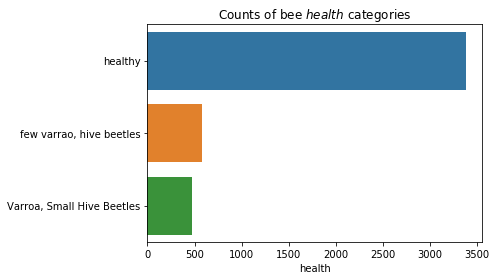

In [8]:
health_counts = data["health"].value_counts()

plt.title("Counts of bee $health$ categories")
sns.barplot(x = health_counts, y = health_counts.index);

### Establishing baseline model

In [9]:
data["has_varroa"].value_counts(normalize = True)

0    0.763021
1    0.236979
Name: has_varroa, dtype: float64

These data are somewhat unbalanced, with the target variable `has_varroa` accounting for almost 24% of the data having the observation of interest.

With 76% of the dataset consisting of healthy bees, this serves as the baseline model's accuracy. Any model with an accuracy significantly higher than 76% can be considered superior to this naive model.

In [10]:
data.groupby("location").mean()[["has_varroa"]]

,has_varroa
location,
"Athens, GA, USA",1
"Athens, Georgia, USA",1
"Des Moines, IA, USA",0
"Keene, NH, USA",0
"New Orleans, LA, USA",0
"San Jose, CA, USA",0
"Saratoga, CA, USA",0


Apparently only two locations actually showcased varroa, which could train the model on factors unrelated to infected bees, such as classifying aspects of the location (parts of the image background) and/or the photographer's style (angle of shot, orientation, etc.).

### Clearing unnecessary columns
While a typical model would benefit from the image annotations, I'm attempting to make practical classifications based solely on a user's image. As such, most of the columns in the dataset are irrelevant.

In [11]:
data.head(1)

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,has_varroa
74,017_029.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker,0


In [12]:
data = data[["file","has_varroa"]]
data.head(2)

,file,has_varroa
74,017_029.png,0
75,017_015.png,0


###  Visualizing file images
Viewing the actual images that will be used to train the CNN may help inform how best to approach potentially cleaning and/or preparing the images for classification training.

In [13]:
def show_image(file, ax, title = None, IMAGE_FILE_ROOT = './data/bee_imgs/', show_size = False):
    if title:
        ax.set_title(title)
    if type(file) == str:
        ax.imshow(imageio.imread("{}{}".format(IMAGE_FILE_ROOT,file)))
    else: # assumed image directly supplied
        ax.imshow(file)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

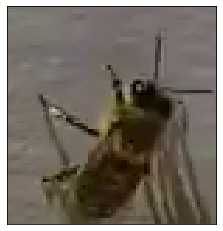

In [14]:
show_image("017_029.png", plt)

In [15]:
def show_images(files, titles):
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(files)/cols)),ncols=cols, figsize=(14,8))
    ax = ax.flatten()
    for i, file in enumerate(files):
            show_image(file, ax = ax[i], title = titles[i])
    plt.show()

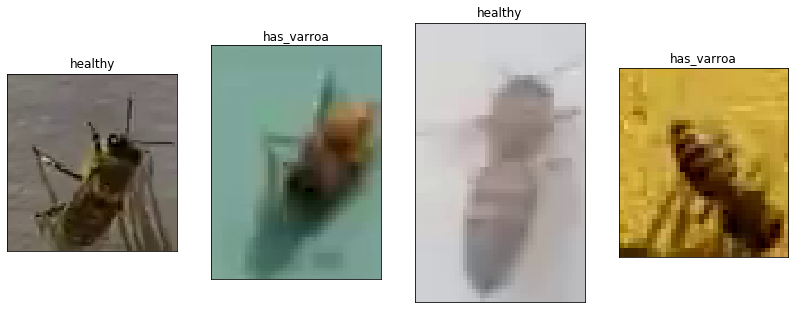

In [16]:
show_images(data["file"][::1200],list(data["has_varroa"].map({1:"has_varroa",0:"healthy"})[::1200]))

These pixelated images will be digested and processed by the CNN to descern the bee's classfication. 

However, from quickly viewing just a handful of these images, I'm concerned about the low resolution and inconsistent quality of the data. For example, the 2nd image above shows a bee with varroa, which appears as little more than a blob. 

Can a CNN accurately discern the difference between one blob and another? If it can, is it really learning to distinguish an infected bee from a healthy one, or is it learning to distinguish something else, like the background?

Additionally, I'm concerned the inconsistent image sizes may pose a problem when inputting the pixel data into the convolutional layer. These images will need to be standardized, and using either resizing or rescaling will either lose data or distort the image (effectively using augmented data).

### Discovering most frequent image shape
Since the CNN will need a consistent format, I'll use the most frequent image size by default and transform any images not matching those parameters.

In [17]:
def get_image_sizes(files):
    IMAGE_FILE_ROOT = './data/bee_imgs/'

    out = {}
    for file in files:
        h, w, rbg = imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)).shape
        size = "{}x{}".format(h,w)
        if not out.get(size):
            out[size] = 0
        out[size] += 1
    return out

In [18]:
sizes = get_image_sizes(data["file"])

In [19]:
max(sizes.values()) / sum(sizes.values())

0.0033821871476888386

Since only about .3% (12 total) of the total image data has the most frequent size, we'll have to rethink this approach. Instead, perhaps an average of the widths and heights can be used to coerce images to the same size.

In [20]:
def get_image_wh(files):
    IMAGE_FILE_ROOT = './data/bee_imgs/'

    widths = []
    heights = []
    for file in files:
        h, w, rbg = imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)).shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

In [21]:
def get_best_average(dist, cutoff = .5):
    # requires single peak normal-like distribution
    hist, bin_edges = np.histogram(dist, bins = 25);
    total_hist = sum(hist)
    hist_edges = [(vals[0]/total_hist,vals[1]) for vals in zip(hist, bin_edges)]
    hist_edges.sort(key = lambda x: x[0])
    lefts = []
    while cutoff > 0:
        vals = hist_edges.pop()
        cutoff -= vals[0]
        lefts.append(vals[1])
    diff = np.abs(np.diff(lefts)[0]) # same diff b/c of bins
    leftmost = min(lefts)
    rightmost = max(lefts) + diff
    return int(np.round(np.mean([rightmost,leftmost])))

In [22]:
wh = get_image_wh(data["file"])

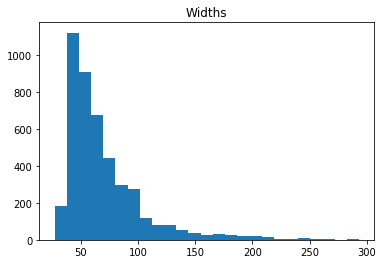

In [23]:
plt.title("Widths")
plt.hist(wh[0], bins = 25);

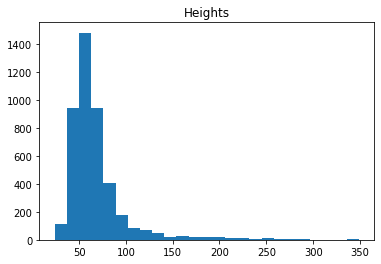

In [24]:
plt.title("Heights")
plt.hist(wh[1], bins = 25);

In [25]:
IDEAL_WIDTH, IDEAL_HEIGHT = get_best_average(wh[0]), get_best_average(wh[1])
IDEAL_WIDTH, IDEAL_HEIGHT

(54, 50)

### Resizing images
With an ideal height and width set, we can create a simple function responsible for handling the resizing.

In [26]:
def resize_image(image, resizing = (28,28)):
    return resize(image, resizing, anti_aliasing=True, mode = "constant")

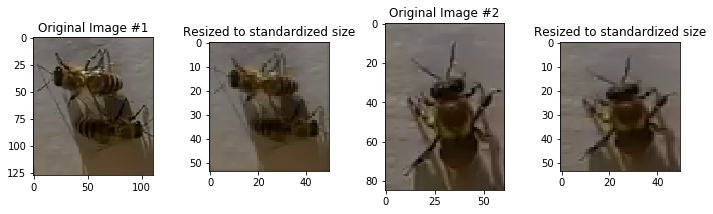

In [27]:
resizing = (IDEAL_WIDTH, IDEAL_HEIGHT, 3)
f, axes = plt.subplots(ncols = 4, figsize = (10,14))

old_image_1 = imageio.imread("./data/bee_imgs/017_100.png")
show_image(old_image_1, ax = axes[0], title = "Original Image #1", show_size = True)
new_image_1 = resize_image(old_image_1, resizing)
show_image(new_image_1, ax = axes[1], title = "Resized to standardized size", show_size = True)

old_image_2 = imageio.imread("./data/bee_imgs/017_010.png")
show_image(old_image_2, ax = axes[2], title = "Original Image #2", show_size = True)
new_image_2 = resize_image(old_image_2, resizing)
show_image(new_image_2, ax = axes[3], title = "Resized to standardized size", show_size = True)
plt.tight_layout()

For the most part, the images are not terribly perturbed by resizing them to a standard width and height. Of course, these augmented images must be taken into consideration when interpreting the results and the applicability of the model to real world images, which may require a more nuanced method for standardizing incoming images.

## Model Preparation
We may want to consider boosting (bootstrapping) the minority class (has_varroa), given unbalanced classes.

In [89]:
def get_image_data(files, resizing):
    IMAGE_FILE_ROOT = './data/bee_imgs/' 
    return np.asanyarray([resize_image(imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)), resizing) for file in files])

In [90]:
resizing = (IDEAL_WIDTH, IDEAL_HEIGHT, 3) # needed to remove 4th alpha channel

X = get_image_data(data["file"], resizing)

y = data["has_varroa"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y, random_state = random_state)

y_train_dummy = np_utils.to_categorical(y_train,2)
y_test_dummy  = np_utils.to_categorical(y_test,2)

In [150]:
# import tensorflow as tf
# from keras import backend as K

# def auc(y_true, y_pred):
#     auc = tf.metrics.auc(y_true, y_pred)[1]
#     K.get_session().run(tf.local_variables_initializer())
#     return auc

In [151]:
initial_filters = 16
density_units = 32

batch_size = 64
epochs = 16

kernel_size = 3
dropout = .5
activation_func = "relu"

# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters   = initial_filters,         # number of filters
                     kernel_size = kernel_size,        # height/width of filter
                     activation  = activation_func,      # activation function 
                     input_shape = (IDEAL_WIDTH,IDEAL_HEIGHT,3)) # shape of input (image)
               )

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# Add another convolutional layer.
cnn_model_2.add(Conv2D(filters = initial_filters * 2,
                       kernel_size = kernel_size,
                       activation=activation_func))

# Add another pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2)))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(density_units * 2, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a densely-connected layer with 32 neurons.
cnn_model_2.add(Dense(density_units, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a final layer with 2 neurons.
cnn_model_2.add(Dense(2, activation='softmax'))

# Compile model
cnn_model_2.compile(loss='categorical_crossentropy',
                    optimizer="adam",
                    metrics=["binary_accuracy"])

# Fit model on training data
history = cnn_model_2.fit(X_train,
                          y_train_dummy,
                          batch_size=batch_size,
                          validation_data=(X_test, y_test_dummy),
                          epochs=epochs,
                          verbose=1)

W0807 13:52:20.641678 29388 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 13:52:20.674862 29388 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 13:52:20.866959 29388 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 13:52:20.890223 29388 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0807 13:52:20.925750 29388 deprecation_wrapper.py:119] From C:

Train on 3326 samples, validate on 1109 samples
Epoch 1/16
3326/3326 [==============================] - 5s 2ms/step - loss: 0.4474 - binary_accuracy: 0.7781 - val_loss: 0.2750 - val_binary_accuracy: 0.8972
Epoch 2/16
3326/3326 [==============================] - 5s 1ms/step - loss: 0.2883 - binary_accuracy: 0.9014 - val_loss: 0.1936 - val_binary_accuracy: 0.9288
Epoch 3/16
3326/3326 [==============================] - 5s 2ms/step - loss: 0.2275 - binary_accuracy: 0.9375 - val_loss: 0.1611 - val_binary_accuracy: 0.9396
Epoch 4/16
3326/3326 [==============================] - 5s 1ms/step - loss: 0.2008 - binary_accuracy: 0.9456 - val_loss: 0.1856 - val_binary_accuracy: 0.9351
Epoch 5/16
3326/3326 [==============================] - 5s 2ms/step - loss: 0.1648 - binary_accuracy: 0.9531 - val_loss: 0.1337 - val_binary_accuracy: 0.9513
Epoch 6/16
3326/3326 [==============================] - 4s 1ms/step - loss: 0.1446 - binary_accuracy: 0.9618 - val_loss: 0.1180 - val_binary_accuracy: 0.9693
Epoc

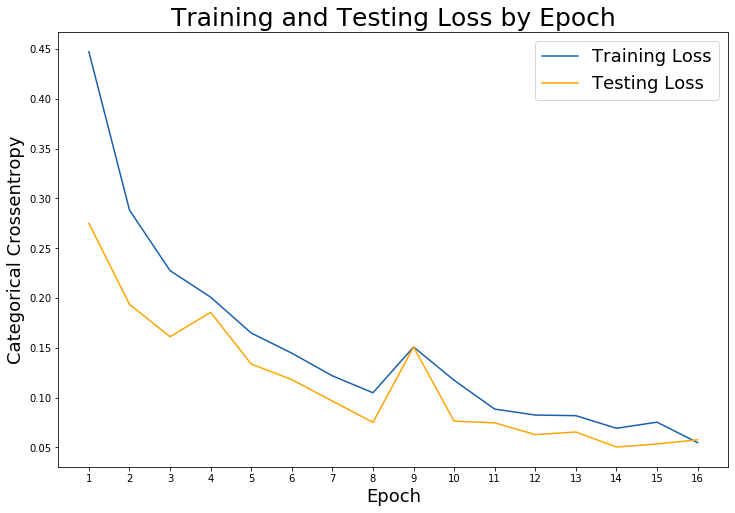

In [152]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(len(test_loss)), labels = range(1,len(test_loss) + 1))
plt.legend(fontsize = 18);

In [101]:
cnn_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 42, 42, 16)        448       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 19, 19, 32)        4640      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 576)               0         
__________

In [153]:
predictions = cnn_model_2.predict_classes(X_test)

results = predictions - y_test
results.value_counts(normalize = True)

 0    0.982867
 1    0.009919
-1    0.007214
Name: has_varroa, dtype: float64

We see 1.11% of the test predictions were false positives, while .8% were false negatives.

In [28]:
def conf_matrix_stats(y_test, preds):
    ''' Return key confusion matrix metrics given true and predicted values'''
    cm = confusion_matrix(y_test, preds)
    TP, FP, FN, TN, = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
    total = (TP + FP + FN + TN)
    acc = (TP + TN ) / total
    miss = 1 - acc
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    return {"accuracy": acc, "miss_rate": miss, "sensitivity": sens, "specification": spec, "precision": prec}

In [29]:
conf_matrix_stats(y_test, predictions)

NameError: name 'y_test' is not defined

This model's __accuracy is 99.2%__ with a specificity of 99.97% and a sensativity of 94.6%.

As this model performs much better than the baseline model, we can conclude this model is a more useful classifier.

## Evaluating Model Errors

#### False positives

In [69]:
def show_bad_image(file, ax, title = None, IMAGE_FILE_ROOT = './data/bee_imgs/'):
    image = imageio.imread("{}{}".format(IMAGE_FILE_ROOT,file)) if type(file) == str else file
    shape = image.shape
    if title:
        ax.set_title(f"Orig. size: {shape[0]}x{shape[1]}\n{title}")
    ax.imshow(resize_image(image, resizing))
    ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

In [67]:
def show_bad_images(files, titles = None, ncols = 4, height = 4):
    nrows = int(np.ceil(len(files)/ncols))
    f, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(10,nrows * height))
    ax = ax.flatten()
    for i, file in enumerate(files):
            show_bad_image(file, ax = ax[i], title = titles[i] if titles else titles)
    plt.tight_layout()
    plt.show()

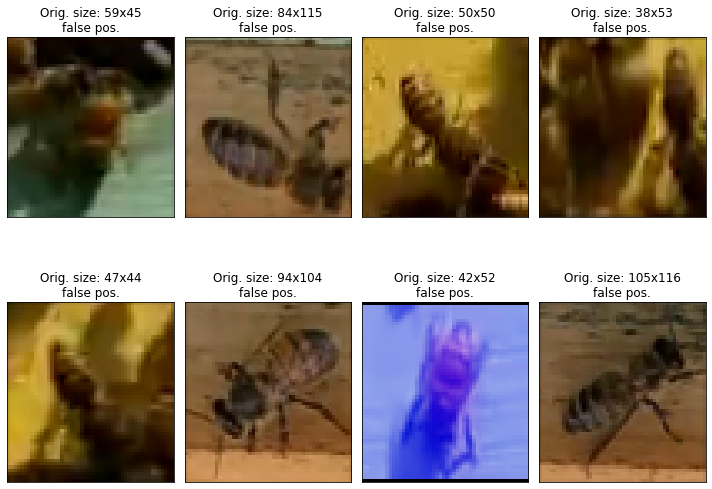

In [160]:
false_positive_files = data.loc[results[results == -1].index]["file"]
show_bad_images(false_positive_files, ["false pos."] * len(false_positive_files))

We can see these false positives have some common issues that are likely throwing off the neural network.

1. __Rescaling artifacts__ - the rescaling step may have drastically altered the original image
2. __Orientation__ - many of the bees pictured here are upside-down. This may be remedied by retraining the network using rotated versions of the training data.
3. __Patterned background__ - a striped pattern is a signature part of the bee abdomen. Some of these falsely classified images could have been the result of the network mistaking the background for a larger bee with a "smaller" mite on it.
4. __Shadows__ - a number of these images display prominent shadows, which may have confused the network.

#### False negatives

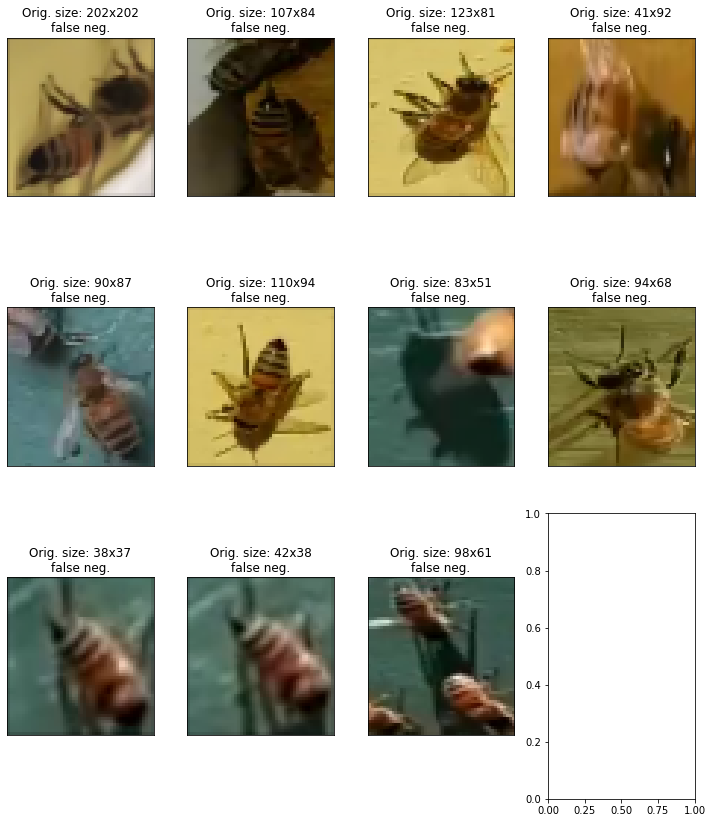

In [161]:
false_negative_files = data.loc[results[results == 1].index]["file"]
show_bad_images(false_negative_files, ["false neg."] * len(false_negative_files))

We can see these false negatives show some common issues as well:

1. __Shadows__ - like before, a number of these images display prominent shadows, which may have confused the network.
2. __Partials__ - many of these images show either more than 1 bee or only parts of bees. This could easily confuse the network, as these kinds of images are essentially incomplete.

## Retraining with rotated images

In [32]:
def get_image_data(files, resizing):
    IMAGE_FILE_ROOT = './data/bee_imgs/'
    return np.asanyarray([resize_image(imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)), resizing) for file in files])

In [81]:
def get_rotated_image_data(files, resizing):
    IMAGE_FILE_ROOT = './data/bee_imgs/'
    out = []
    for file in files:
        merger = []
        img = resize_image(imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)), resizing)
        merger.append(img)
        merger.extend([rotate(img, angle) for angle in range(90,360,90)])
        merger.extend([np.flipud(unflipped_img) for unflipped_img in merger])
        out.extend(merger)
    return np.asanyarray(out)

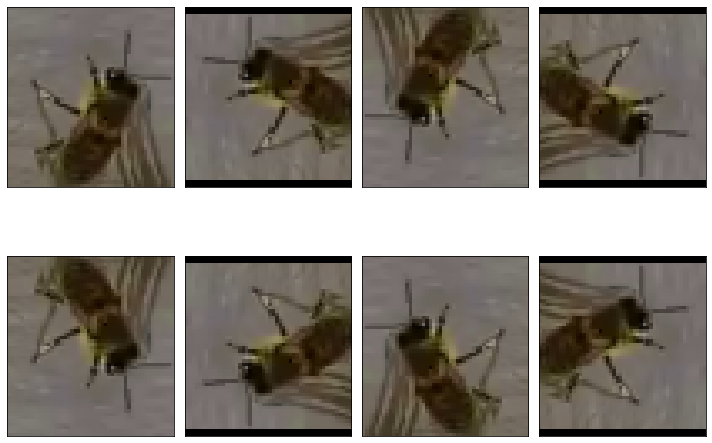

In [73]:
show_bad_images(get_rotated_image_data(data["file"].iloc[0:1], resizing))

Each image is rotated in all 4 direction and mirrored. This ensures the model is trained on as many possible orientations as possible.

In [92]:
new_X = get_rotated_image_data(data["file"], resizing)
new_y = np.repeat(y,8) # each image is replicated 8 times, essentially

In [99]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size = .25, stratify = new_y, random_state = random_state)

y_train_dummy = np_utils.to_categorical(y_train,2)
y_test_dummy  = np_utils.to_categorical(y_test,2)

In [100]:
initial_filters = 16
density_units = 32

batch_size = 64
epochs = 8

kernel_size = 3
dropout = .5
activation_func = "relu"

# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters   = initial_filters,         # number of filters
                     kernel_size = kernel_size,        # height/width of filter
                     activation  = activation_func,      # activation function 
                     input_shape = (IDEAL_WIDTH,IDEAL_HEIGHT,3)) # shape of input (image)
               )

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# Add another convolutional layer.
cnn_model_2.add(Conv2D(filters = initial_filters * 2,
                       kernel_size = kernel_size,
                       activation=activation_func))

# Add another pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2)))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(density_units * 2, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a densely-connected layer with 32 neurons.
cnn_model_2.add(Dense(density_units, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a final layer with 2 neurons.
cnn_model_2.add(Dense(2, activation='softmax'))

# Compile model
cnn_model_2.compile(loss='categorical_crossentropy',
                    optimizer="adam",
                    metrics=["binary_accuracy"])

# Fit model on training data
history = cnn_model_2.fit(X_train,
                          y_train_dummy,
                          batch_size=batch_size,
                          validation_data=(X_test, y_test_dummy),
                          epochs=epochs,
                          verbose=1)

W0807 23:14:44.014412 27136 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 23:14:44.132637 27136 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 23:14:44.162074 27136 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 23:14:44.210942 27136 deprecation_wrapper.py:119] From C:\Users\rick_c137\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0807 23:14:44.251799 27136 deprecation_wrapper.py:119] From C:

Train on 26610 samples, validate on 8870 samples
Epoch 1/8
26610/26610 [==============================] - 30s 1ms/step - loss: 0.2381 - binary_accuracy: 0.9078 - val_loss: 0.1232 - val_binary_accuracy: 0.9572
Epoch 2/8
26610/26610 [==============================] - 24s 908us/step - loss: 0.1264 - binary_accuracy: 0.9676 - val_loss: 0.0699 - val_binary_accuracy: 0.9842
Epoch 3/8
26610/26610 [==============================] - 26s 970us/step - loss: 0.0819 - binary_accuracy: 0.9808 - val_loss: 0.0941 - val_binary_accuracy: 0.9790
Epoch 4/8
26610/26610 [==============================] - 25s 948us/step - loss: 0.0690 - binary_accuracy: 0.9858 - val_loss: 0.0813 - val_binary_accuracy: 0.9782
Epoch 5/8
26610/26610 [==============================] - 26s 980us/step - loss: 0.0632 - binary_accuracy: 0.9880 - val_loss: 0.0879 - val_binary_accuracy: 0.9766
Epoch 6/8
26610/26610 [==============================] - 26s 968us/step - loss: 0.0618 - binary_accuracy: 0.9881 - val_loss: 0.0604 - val_binar

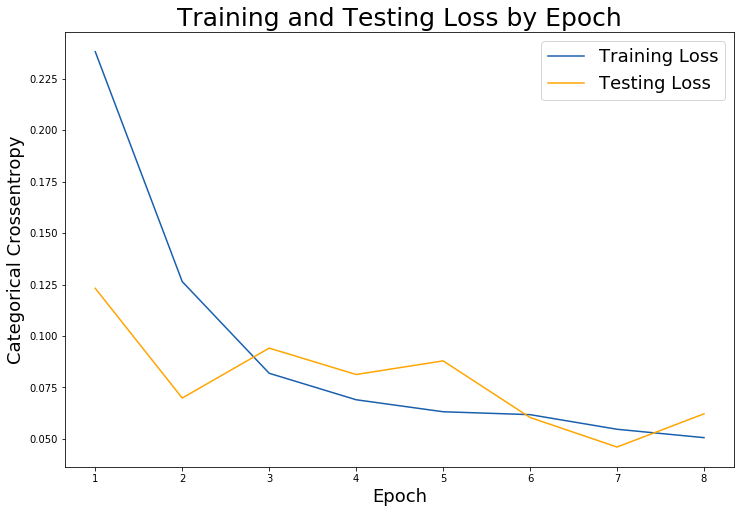

In [101]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(len(test_loss)), labels = range(1,len(test_loss) + 1))
plt.legend(fontsize = 18);

In [104]:
predictions2 = cnn_model_2.predict_classes(X_test)
results2 = predictions2 - y_test
results2.value_counts(normalize = True)

 0    0.985908
-1    0.010598
 1    0.003495
Name: has_varroa, dtype: float64

In [105]:
conf_matrix_stats(y_test, predictions2)

{'accuracy': 0.9859075535512966,
 'miss_rate': 0.014092446448703444,
 'sensitivity': 0.9552806850618458,
 'specification': 0.995419621749409,
 'precision': 0.984796468857283}

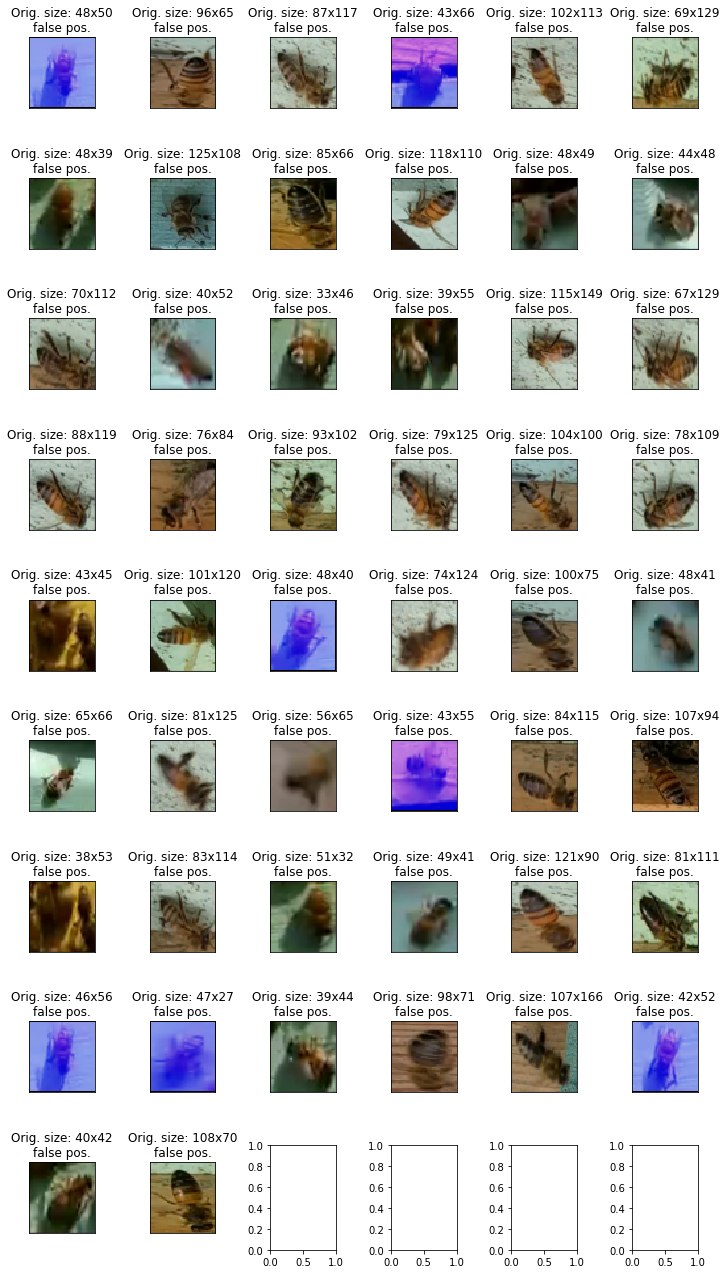

In [106]:
false_positive_files = data.loc[results2[results2 == -1].index]["file"].unique()
show_bad_images(false_positive_files, ["false pos."] * len(false_positive_files), ncols = 6, height = 2)

- Many images are completely lacking in definition
- Another noteworthy trend is the darker exoskeletons of certain species of bees, which make them more prone to being falsely classified. This model only takes the images as they are and does not take any additional data into account. If a bee "species" could be included, it would allow the model to more accurately distinguish darker bees with varroa mites.
- confusing background

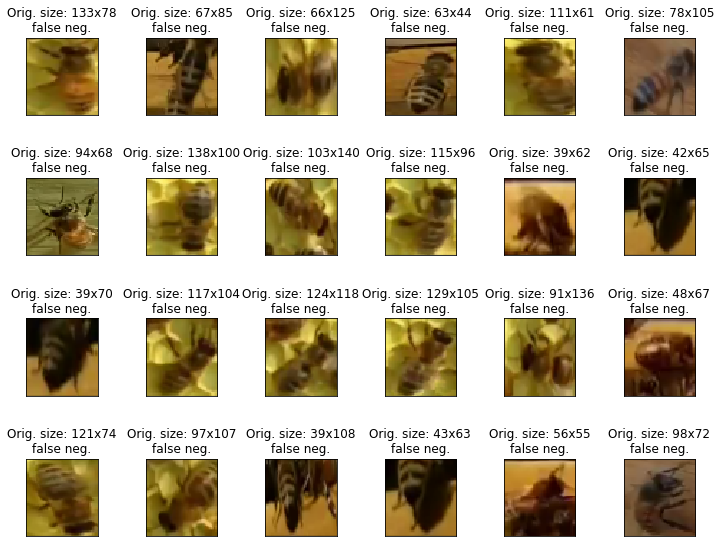

In [108]:
false_negative_files = data.loc[results2[results2 == 1].index]["file"].unique()
show_bad_images(false_negative_files, ["false neg."] * len(false_negative_files), ncols = 6, height = 2)

## Removing color!

With only 3 false negatives, this mod

## Bootstrapping minority class

In [124]:
def bootstrap(dataset, boot_col, minority_class, perc_inc = 1.0):
    sample = dataset[dataset[boot_col]==minority_class].sample(frac = 1.0, replace = True, random_state = random_state)
    return pd.concat([dataset, sample])

In [125]:
bootstrap_data = bootstrap(data, boot_col = "has_varroa", minority_class = 1)

In [126]:
bootstrap_data.shape

(4542, 2)

In [127]:
bootstrap_data["has_varroa"].value_counts(normalize = True)

0    0.745046
1    0.254954
Name: has_varroa, dtype: float64

Now the unbalanced class is more in line

In [128]:
new_X = get_rotated_image_data(bootstrap_data["file"], resizing)
new_y = np.repeat(bootstrap_data["has_varroa"],4)
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size = .25, stratify = new_y, random_state = random_state)

y_train_dummy = np_utils.to_categorical(y_train,2)
y_test_dummy  = np_utils.to_categorical(y_test,2)

In [129]:
initial_filters = 16
density_units = 32

batch_size = 64
epochs = 16

kernel_size = 3
dropout = .5
activation_func = "relu"

# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters   = initial_filters,         # number of filters
                     kernel_size = kernel_size,        # height/width of filter
                     activation  = activation_func,      # activation function 
                     input_shape = (IDEAL_WIDTH,IDEAL_HEIGHT,3)) # shape of input (image)
               )

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# Add another convolutional layer.
cnn_model_2.add(Conv2D(filters = initial_filters * 2,
                       kernel_size = kernel_size,
                       activation=activation_func))

# Add another pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2)))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(density_units * 2, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a densely-connected layer with 32 neurons.
cnn_model_2.add(Dense(density_units, activation=activation_func))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(dropout))

# Add a final layer with 2 neurons.
cnn_model_2.add(Dense(2, activation='softmax'))

# Compile model
cnn_model_2.compile(loss='categorical_crossentropy',
                    optimizer="adam",
                    metrics=[auc])

# Fit model on training data
history = cnn_model_2.fit(X_train,
                          y_train_dummy,
                          batch_size=batch_size,
                          validation_data=(X_test, y_test_dummy),
                          epochs=epochs,
                          verbose=1)

Train on 13626 samples, validate on 4542 samples
Epoch 1/16
13626/13626 [==============================] - 10s 710us/step - loss: 0.3636 - auc: 0.8365 - val_loss: 0.1659 - val_auc: 0.9305
Epoch 2/16
13626/13626 [==============================] - 8s 592us/step - loss: 0.1739 - auc: 0.9540 - val_loss: 0.0811 - val_auc: 0.9656
Epoch 3/16
13626/13626 [==============================] - 8s 564us/step - loss: 0.0909 - auc: 0.9738 - val_loss: 0.0647 - val_auc: 0.97960928 - auc:
Epoch 4/16
13626/13626 [==============================] - 8s 607us/step - loss: 0.0655 - auc: 0.9832 - val_loss: 0.0548 - val_auc: 0.9860
Epoch 5/16
13626/13626 [==============================] - 8s 570us/step - loss: 0.0751 - auc: 0.9878 - val_loss: 0.0477 - val_auc: 0.9889
Epoch 6/16
13626/13626 [==============================] - 8s 585us/step - loss: 0.0441 - auc: 0.9902 - val_loss: 0.0317 - val_auc: 0.9913
Epoch 7/16
13626/13626 [==============================] - 7s 549us/step - loss: 0.0567 - auc: 0.9921 - val_loss

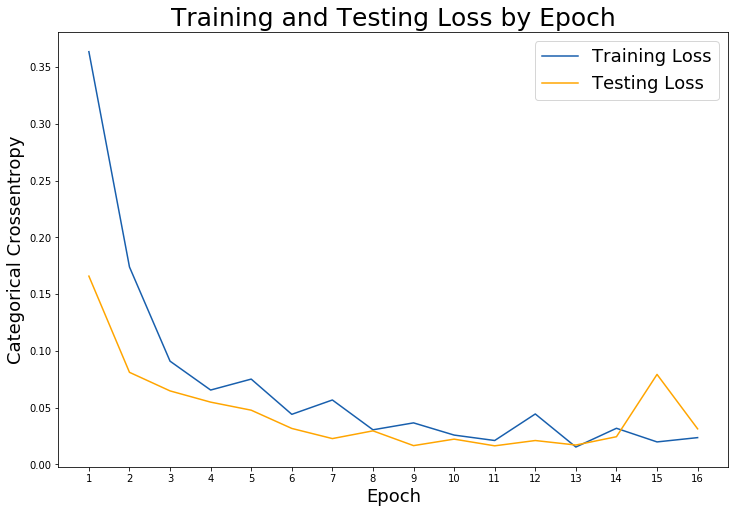

In [130]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(len(test_loss)), labels = range(1,len(test_loss) + 1))
plt.legend(fontsize = 18);

In [131]:
predictions3 = cnn_model_2.predict_classes(X_test)
results3 = predictions3 - y_test
results3.value_counts(normalize = True)

 0    0.992294
-1    0.006165
 1    0.001541
Name: has_varroa, dtype: float64

In [132]:
conf_matrix_stats(y_test, predictions3)

{'accuracy': 0.9922941435490973,
 'miss_rate': 0.007705856450902715,
 'sensitivity': 0.9758203799654577,
 'specification': 0.9979314420803782,
 'precision': 0.9938434476693052}

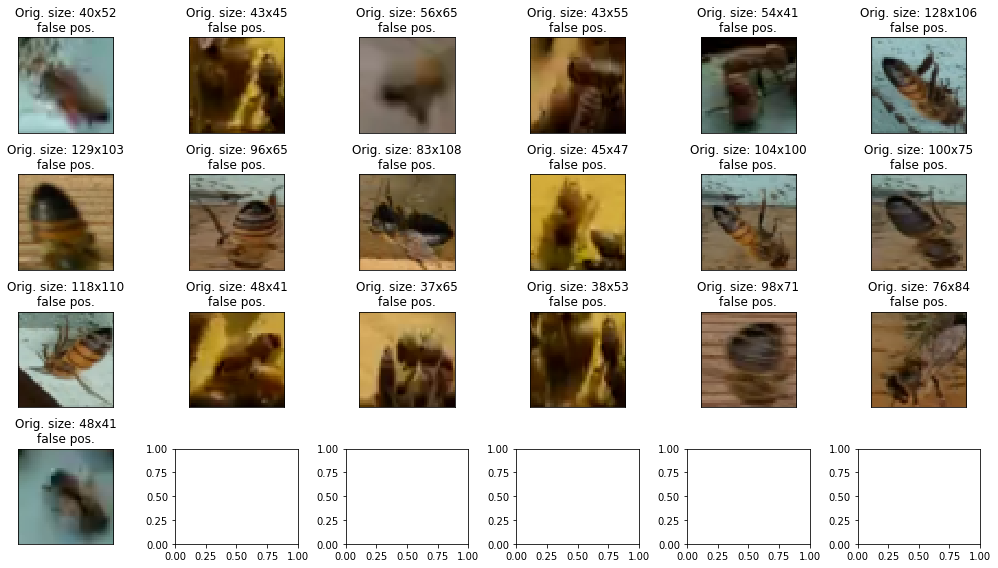

In [133]:
false_positive_files = data.loc[results3[results3 == -1].index]["file"].unique()
show_bad_images(false_positive_files, ["false pos."] * len(false_positive_files), ncols = 6, height = 2)

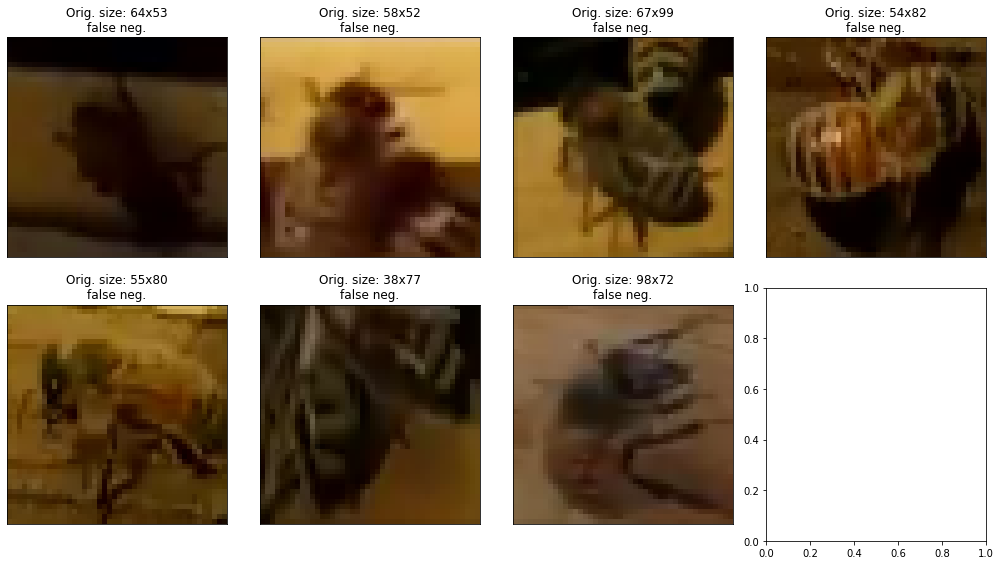

In [134]:
false_negative_files = data.loc[results3[results3 == 1].index]["file"].unique()
show_bad_images(false_negative_files, ["false neg."] * len(false_negative_files))

## Visualizing the CNN
- https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/
- Try gif

## Source Documentation
- [Honey Bee Annotated Image Dataset (Kaggle)](https://www.kaggle.com/jenny18/honey-bee-annotated-images)